In [1]:
# polars dataframe manipulations
import polars as pl
pl.Config.set_fmt_str_lengths(200)

# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
# load parquet files
weth_usdc_df = pl.read_parquet('weth_usdc_df')

In [3]:
weth_usdc_df.shape

(247732, 13)

In [4]:
weth_usdc_df['endpoint'].unique()

endpoint
str
"""uniswap-v3-arbitrum"""
"""uniswap-v3-ethereum"""


### Analysis Part 1: Required
* Show the daily volume of transactions where USDC was swapped for the other token.
* Show the daily volume of transactions where the token was swapped for USDC.
* Show the aggregate daily total swap volume of your chosen pool.
* Show the daily number of transactions that used this pool.

#### WETH/USDC Volume Per Token

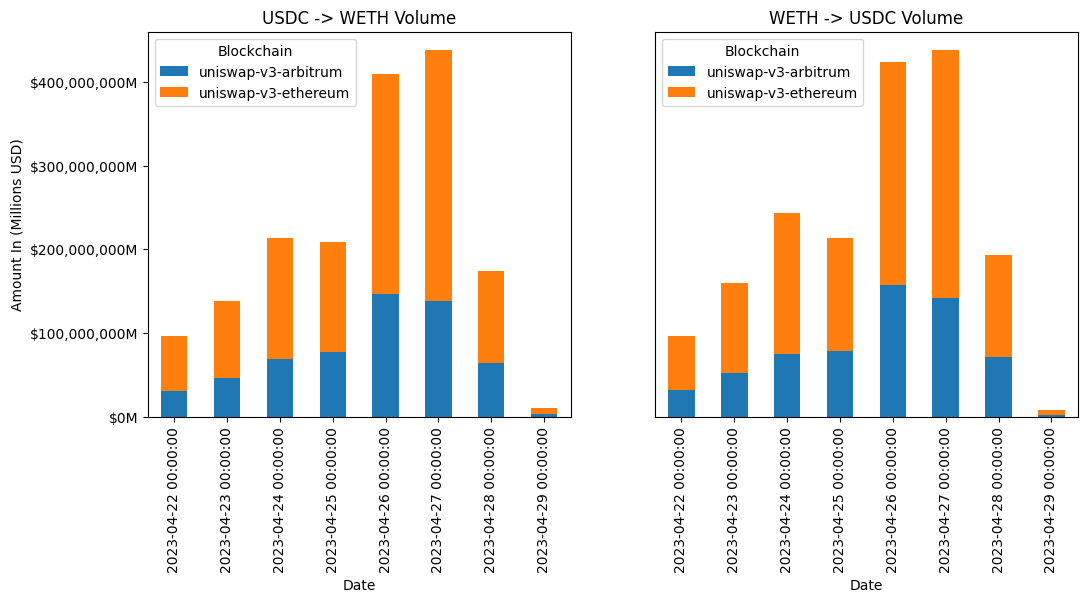

In [5]:
# group the dataframe by date and endpoint, and sum the amountInUSD column
usdc_df = weth_usdc_df.filter(pl.col("tokenIn_symbol") == 'USDC')
daily_usdc_group = usdc_df.groupby(pl.from_epoch(usdc_df["timestamp"], time_unit="d"), 'endpoint')\
    .agg(pl.sum("amountInUSD").alias("amountInUSD_sum"))\
    .sort(['timestamp', 'amountInUSD_sum'])

# group the dataframe by date and endpoint, and sum the amountInUSD column
weth_df = weth_usdc_df.filter(pl.col("tokenIn_symbol") == 'WETH')
daily_weth_group = weth_df.groupby(pl.from_epoch(weth_df["timestamp"], time_unit="d"), 'endpoint')\
    .agg(pl.sum("amountInUSD").alias("amountInUSD_sum"))\
    .sort(['timestamp', 'amountInUSD_sum'])

# convert to pandas dataframe and plot as a stacked bar plot
daily_usdc_group = daily_usdc_group.to_pandas()
daily_weth_group = daily_weth_group.to_pandas()

# create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# plot the first bar chart in the first subplot
ax1 = daily_usdc_group.pivot_table(values='amountInUSD_sum', index='timestamp', columns='endpoint')\
    .plot.bar(stacked=True, ax=axes[0])

# add title, x label, and y label to the first subplot
ax1.set_title('USDC -> WETH Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount In (Millions USD)')

# format y axis ticks to show millions in USD in the first subplot
fmt = '${x:,.0f}M'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)

# plot the second bar chart in the second subplot
ax2 = daily_weth_group.pivot_table(values='amountInUSD_sum', index='timestamp', columns='endpoint')\
    .plot.bar(stacked=True, ax=axes[1])

# add title, x label, and y label to the second subplot
ax2.set_title('WETH -> USDC Volume')
ax2.set_xlabel('Date')

# hide y axis
ax2.get_yaxis().set_visible(False)

# change legend from 'endpoint' to 'blockchain'
ax1.legend(title='Blockchain')
ax2.legend(title='Blockchain')


plt.show()

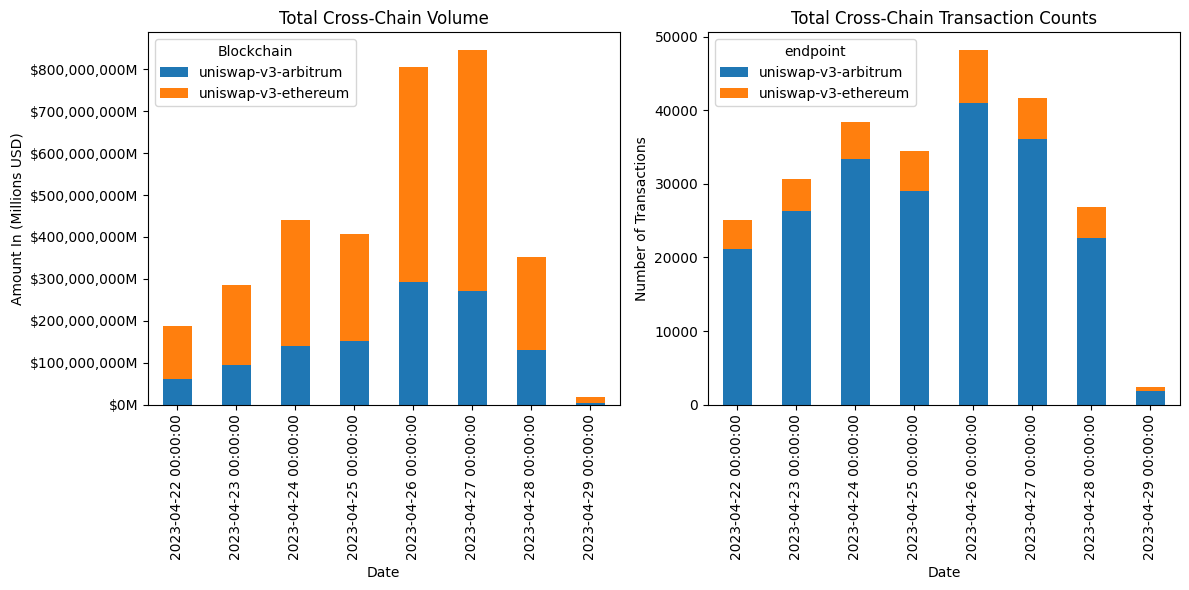

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot total cross-chain volume
ax1 = axs[0]
daily_group = weth_usdc_df.groupby(pl.from_epoch(weth_usdc_df["timestamp"], time_unit="d"), 'endpoint')\
    .agg(pl.sum("amountInUSD").alias("amountInUSD_sum"))\
    .sort(['timestamp', 'amountInUSD_sum'])

daily_group = daily_group.to_pandas()
daily_group.pivot_table(values='amountInUSD_sum', index='timestamp', columns='endpoint')\
    .plot.bar(stacked=True, ax=ax1)

ax1.set_title('Total Cross-Chain Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount In (Millions USD)')

fmt = '${x:,.0f}M'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)

ax1.legend(title='Blockchain')

# plot total cross-chain transaction counts
ax2 = axs[1]
daily_count_group = weth_usdc_df.groupby(pl.from_epoch(weth_usdc_df["timestamp"], time_unit="d"), 'endpoint')\
    .agg(pl.count("endpoint").alias("row_count"))\
    .sort(['timestamp', 'row_count'])

daily_count_group = daily_count_group.to_pandas()
daily_count_group.pivot_table(values='row_count', index='timestamp', columns='endpoint')\
    .plot.bar(stacked=True, ax=ax2)

ax2.set_title('Total Cross-Chain Transaction Counts')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

##### Show Volume per Pool Per Endpoint

In [7]:
# Remove "Uniswap V3" from pool name for better visualization
weth_usdc_df = weth_usdc_df.with_columns(pl.col("pool_name").str.replace("Uniswap V3", ""))

In [8]:
# drop WETH/WETH and USDC/USDC pools
pool_names_to_exclude = [" WETH/Wrapped Ether 1%", " USD Coin (PoS) (Wormhole)/USD Coin 0.01%"]
weth_usdc_df = weth_usdc_df.filter(~pl.col("pool_name").is_in(pool_names_to_exclude))

In [9]:
# divide datafreames into two dataframes based on endpoint value
weth_usdc_arb = weth_usdc_df.filter(pl.col("endpoint") == 'uniswap-v3-arbitrum')
weth_usdc_eth = weth_usdc_df.filter(pl.col("endpoint") == 'uniswap-v3-ethereum')

In [10]:
def plot_pool_vol(df: pl.DataFrame, ax=None):
    """
    Plot pool Volume per dataframe
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # group the dataframe by date and endpoint, and sum the amountInUSD column
    daily_pool_group = df.groupby(pl.from_epoch(df["timestamp"], time_unit="d"), 'pool_name')\
        .agg(pl.sum("amountInUSD").alias("amountInUSD_sum"))\
        .sort(['timestamp', 'amountInUSD_sum'])

    # convert to pandas dataframe and plot as a stacked bar plot
    daily_pool_group = daily_pool_group.to_pandas()
    daily_pool_group.pivot_table(values='amountInUSD_sum', index='timestamp', columns='pool_name')\
        .plot.bar(stacked=True, ax=ax)

    # add title, x label, and y label
    ax.set_title(df['endpoint'].unique()[0] + ' Pool Volume')
    ax.set_xlabel('Date')
    ax.set_ylabel('Amount In (Millions USD)')

    # format y axis ticks to show millions in USD
    fmt = '${x:,.0f}M'
    tick = ticker.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)

def plot_pool_count(df: pl.DataFrame, ax=None):
    """
    Plot transaction count per pool in the dataframe
    """
    if ax is None:
        fig, ax = plt.subplots()

    # group the dataframe by date and endpoint, and count the number of rows
    daily_pool_group = df.groupby(pl.from_epoch(df["timestamp"], time_unit="d"), 'pool_name')\
        .agg(pl.count('pool_name').alias('count_swaps'))\
        .sort(['timestamp', 'count_swaps'])

    # convert to pandas dataframe and plot as a stacked bar plot
    daily_pool_group = daily_pool_group.to_pandas()
    daily_pool_group.pivot_table(values='count_swaps', index='timestamp', columns='pool_name')\
        .plot.bar(stacked=True, ax=ax)

    # add title, x label, and y label
    ax.set_title(df['endpoint'].unique()[0] + ' Pool Transaction Counts')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Swaps')


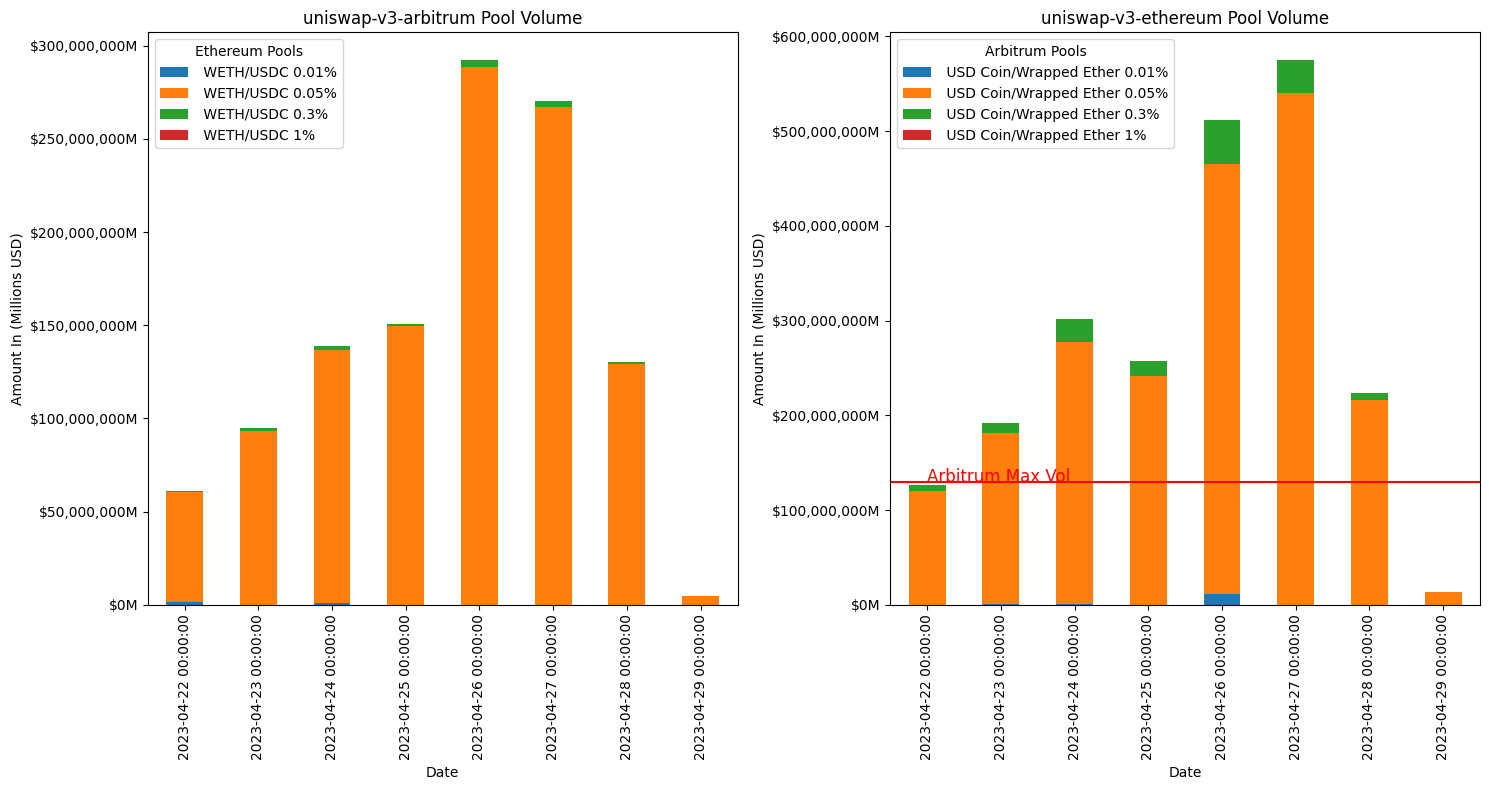

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_pool_vol(weth_usdc_arb, ax=ax1)
plot_pool_vol(weth_usdc_eth, ax=ax2)

# change legend from 'endpoint' to 'blockchain'
ax1.legend(title='Ethereum Pools')
ax2.legend(title='Arbitrum Pools')

# draw horizontal line at 130,000,000 to indicate max volume 
ax2.axhline(y=130000000, color='r', linestyle='-')
# label the horizontal line
ax2.text(0, 130000000, 'Arbitrum Max Vol', color='red', fontsize=12)

plt.tight_layout()
plt.show()

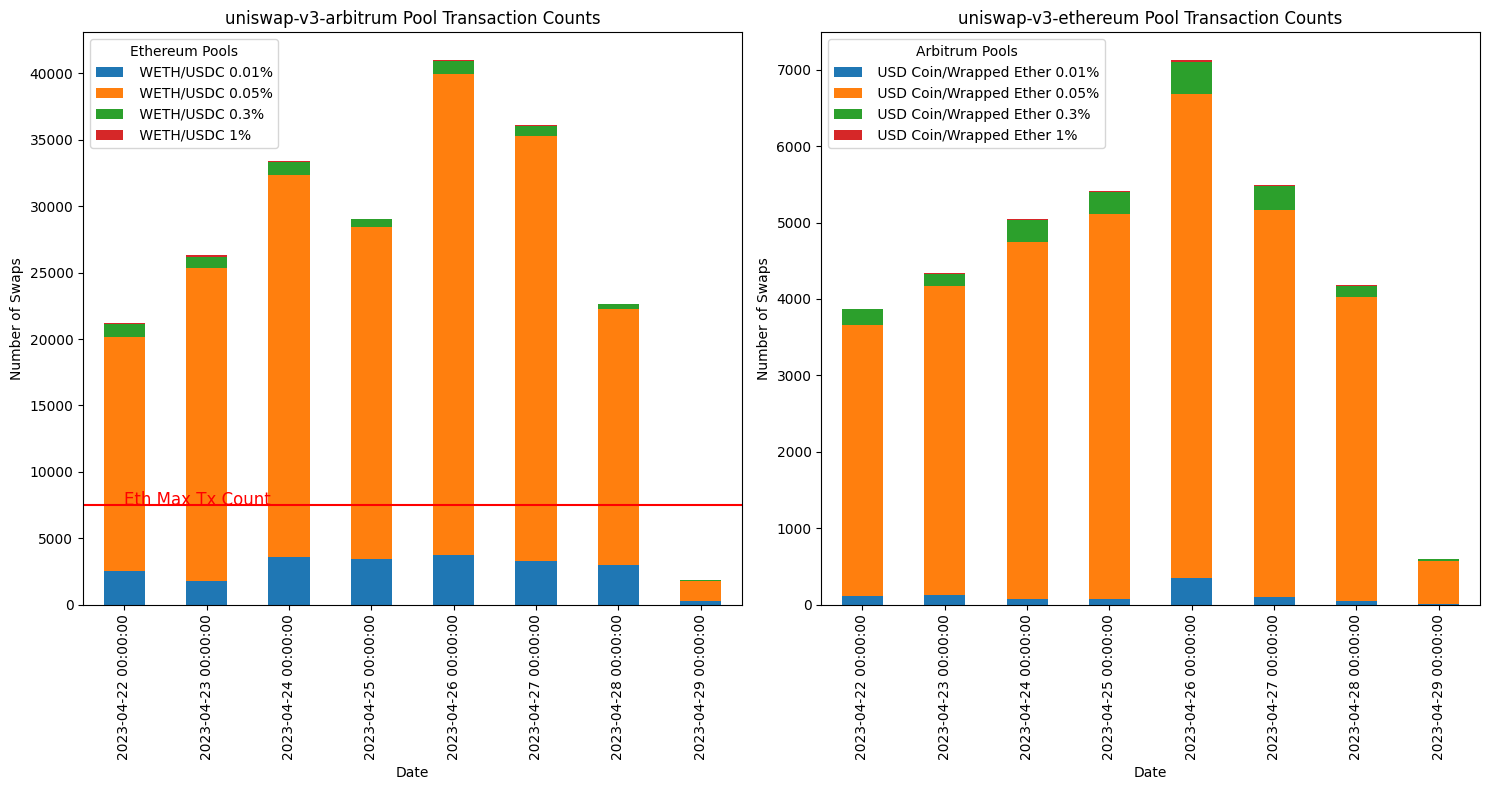

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_pool_count(weth_usdc_arb, ax=ax1)
plot_pool_count(weth_usdc_eth, ax=ax2)

# change legend from 'endpoint' to 'blockchain'
ax1.legend(title='Ethereum Pools')
ax2.legend(title='Arbitrum Pools')

# draw a horizontal line on ax1 at y axis = 7500. This is the "max" transaction count for the Ethereum pools
ax1.axhline(y=7500, color='r', linestyle='-')
ax1.text(0, 7500, 'Eth Max Tx Count', color='red', fontsize=12)

plt.tight_layout()
plt.show()

#### Calculate transaction size quantile per pool 

In [13]:
plot_pool_count(weth_usdc_arb, ax=ax1)
plot_pool_count(weth_usdc_eth, ax=ax2)

In [14]:
# calculate amountInUSD quantile grouped by pool. Polars only lets you calculate a single quantile so switch to pandas.
arb_pool_quantiles = weth_usdc_arb.to_pandas().groupby('pool_name').quantile([.1, 0.25, 0.5, 0.75, .9], interpolation='nearest', numeric_only=True)
eth_pool_quantiles = weth_usdc_eth.to_pandas().groupby('pool_name').quantile([.1, 0.25, 0.5, 0.75, .9], interpolation='nearest', numeric_only=True)

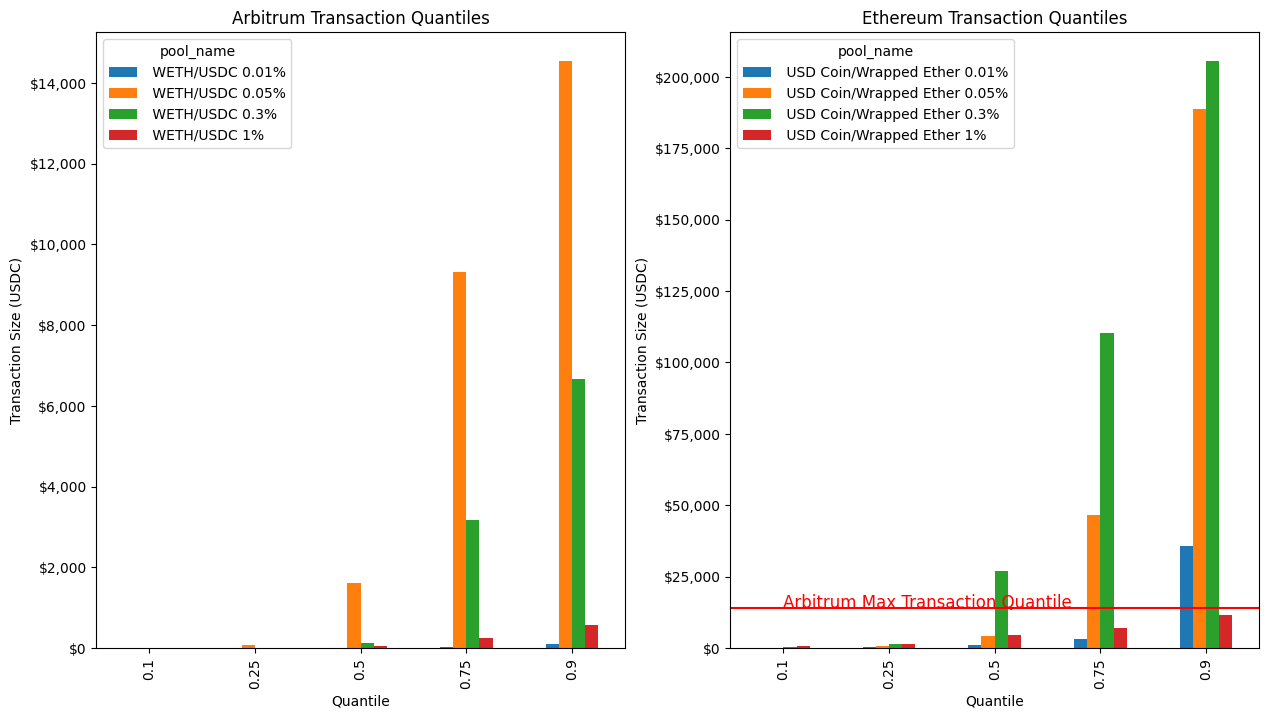

In [15]:
# plot amountInUSD quantiles for each pool
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

arb_pool_quantiles['amountInUSD'].unstack(level=0).plot.bar(ax=ax1)
eth_pool_quantiles['amountInUSD'].unstack(level=0).plot.bar(ax=ax2)

ax1.set_title('Arbitrum Transaction Quantiles')
ax1.set_xlabel('Quantile')
ax1.set_ylabel('Transaction Size (USDC)')

fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)

ax2.set_title('Ethereum Transaction Quantiles')
ax2.set_xlabel('Quantile')
ax2.set_ylabel('Transaction Size (USDC)')

fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax2.yaxis.set_major_formatter(tick)

# draw a horizontal line on ax1 at y axis = 7500. This is the "max" transaction count for the Ethereum pools
ax2.axhline(y=14000, color='r', linestyle='-')
ax2.text(0, 14000, 'Arbitrum Max Transaction Quantile', color='red', fontsize=12)


plt.show()

#### Whale Cross Chain Tx Analysis